In [ ]:
%matplotlib notebook     

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom

import selectpoints

import warnings
warnings.filterwarnings('ignore')

# Point Correspondence

In [2]:
def get_correspondences(imnames,baseim,npoints=4):
    
    """
    The function loads in a set of images which are going to be assembled
    in to a mosaic. It displays the central/base image (first image in the folder) along with each
    peripheral image and allows the user to click to select corresponding
    points between the base image and the peripheral image. It returns the
    images along with the user input. If the original image files were in 
    color the function converts them to grayscale. 
    
    Parameters
    ----------
    imnames : list of str
        Filenames of image files that are going in to the mosaic
    
    baseim : int
        An index which specifies which of the image files is the base image
        
    npoints : int
        How many points are required from the user. Defaults to 4
        
    Returns
    -------
    imgs : list of 2D float arrays
        The arrays for the corresponding images given in imnames. These 
        are gray scale images represented as floats.   
     
    pointmatches : list of SelectPoints objects
        Returns an object whose fields xs and ys contain the point 
        coordinates once the user has clicked  (see selectpoints.py)
        
    """

    nimages = len(imnames)

    #loop over images and load in each one and convert to grayscale
    imgs = list()
    for fname in imnames:  
        print('loading...',fname)
        I = plt.imread(fname)
        
        #convert to float data type if necessary
        if I.dtype == "uint8": I = I.astype(float)
  
        # downsample the image to 1/4 resolution just to make things run quicker
        I = zoom(I,0.25)
        
        #convert from color to grayscale if necessary
        if I.shape[2] == 1: I = np.average(I, axis=-1)
    
        #finally, store the array in our list of images
        imgs.append(I)
 
    #loop over each pair of overlapping images and have the user 
    #click to specify corresponding points
    pointmatches = list()
    for i in range(nimages):
        if (i==baseim):
            continue
        
        fig = plt.figure()
    
        #select points in base image
        ax1 = fig.add_subplot(2,1,1)
        ax1.imshow(imgs[baseim],cmap=plt.cm.gray)
        sp1 = selectpoints.select_k_points(ax1,npoints)

        #corresponding points in overlapping image
        ax2 = fig.add_subplot(2,1,2)
        ax2.imshow(imgs[i],cmap=plt.cm.gray)
        sp2 = selectpoints.select_k_points(ax2,npoints)
 
        pointmatches.append((sp1,sp2))

    return imgs,pointmatches


# Homography Transformations

In [3]:
def compute_homography(pts1,pts2):
    """
    Computes the 3x3 transformation matrix (homography) that when applied to pts1 yields pts2
    
    
    Parameters
    ----------
    pts1 : 2xN array
        2D coordinates of points (to warp)

    pts2 : 2xN array
        target 2D coordinates where points should end up

    Returns
    -------
    numpy.array (dtype=float)
        3x3 array containing the matrix H
        
    """

    #expected dimensions of input
    assert(pts1.shape[0]==2)
    assert(pts2.shape[0]==2)
    assert(pts1.shape[1]>=4)
    assert(pts2.shape[1]>=4)
    
    # “Coefficient” matrix of shape 2n x 8
    A = np.zeros((2 * pts1.shape[1], 8))
    A = np.zeros((2 * pts1.shape[1], 8))
    A[::2, 0] = pts1[0]
    A[::2, 1] = pts1[1]
    A[1::2, 3] = pts1[0]
    A[1::2, 4] = pts1[1]
    A[::2, 6] = pts2[0] * pts1[0] * -1
    A[::2, 7] = pts2[0] * pts1[1] * -1
    A[1::2, 6] = pts2[1] * pts1[0] * -1
    A[1::2, 7] = pts2[1] * pts1[1] * -1
    A[::2, 2] = 1
    A[1::2, 5] = 1
    
    # matrix of dependent variables of shape 2n x 1
    b = np.zeros((1, 2*pts2.shape[1]))
    b[0,::2] = pts2[0]
    b[0,1::2] = pts2[1]
    b = b.T
    
    H = np.linalg.lstsq(A, b, rcond=None)[0]
    H = np.append(H,1)
    H = H.reshape((3,3))
    
    #expected dimension of output
    assert (H.shape==(3,3))
    
    return H

In [4]:
def apply_homography(H,pts):
    """
    Apply a specified homography H to a set of 2D point coordinates
    
    Parameters
    ----------
    H : 3x3 array
        matrix describing the transformation

    pts : 2xN array
        2D coordinates of points to transform
        
    Returns
    -------
    numpy.array (dtype=float)
        2xN array containing the transformed points
        
    """

    #assert expected dimensions of input
    assert(H.shape==(3,3))
    assert(pts.shape[0]==2)
    assert(pts.shape[1]>=1)
    
    # Convert 2D points into homogenous matrix
    homogenous_matrix = np.append(pts, np.ones(pts.shape[1]))
    homogenous_matrix = homogenous_matrix.reshape(pts.shape[0]+1, pts.shape[1])
    
    # Apply transformation
    tpts = H.dot(homogenous_matrix)
    
    # Scale result and pull out first two coordinates
    tpts = np.array([tpts[0]/tpts[2], tpts[1]/tpts[2]])
    
    #make sure transformed pts are correct dimension
    assert(tpts.shape[0]==2)
    assert(tpts.shape[1]==pts.shape[1])
    
    return tpts

# Warping

In [5]:
def warp_images(imgs,baseim,srcpts,basepts):
    """
    Warp a collection of images to align them with a central base image using 
    provided point correspondences to estimate the warping.
    
    
    Parameters
    ----------
    imgs : list of 2D numpy.array (dtype=float)
        The arrays containing the input grayscale images  
  
    baseim : int
        The index of the image which is the central base image
        
    srcpts: list of 2D numpy.array, each of size 2xNclicks 
        x,y coordinates of points clicked by the user for each peripheral image

    basepts : list of 2D numpy.array, each of size 2xNclicks
        x,y coordinates of correponding locations in the base image
        
    Returns
    -------
    imgs_warped: list of 2D numpy.array (dtype=float)
        list of the resulting warped images, all of which will have the same shape
        
    """

    # first estimate all the homographies
    homs = list()
    for i in range(len(imgs)):
        if (i == baseim):
            H =  np.identity(3)#identity matrix
        else:
            H = compute_homography(srcpts[i-1], basepts[i-1]) #compute homography based on clicked points
        homs.append(H)
    
    # compute where the corners of each warped image end up
    # and the upper left and lower-right corners of a rectangle
    # that will enclose all of them
    ul = np.array([0,0])
    lr = np.array([0,0])
    for i in range(len(imgs)):
        #original coorner coordinates
        img_shape = imgs[i].shape
        cx = np.array([[0, 0, img_shape[0], img_shape[0]],[0, img_shape[1], 0, img_shape[1]]])
    
        #warped coordinates
        cx_warped = apply_homography(homs[i],cx)
        
        cur_ul = np.array([np.min(cx_warped[0]), np.min(cx_warped[1])])
        cur_lr = np.array([np.max(cx_warped[0]), np.max(cx_warped[1])])
        
        ul = np.min(np.array([cur_ul, ul]), axis=0)
        lr = np.max(np.array([cur_lr, lr]), axis=0)
    
    #round these to integer valued coordinates
    ul = np.floor(ul)
    lr = np.floor(lr)
    
    # for debugging purposes, you may find it very useful at 
    # this point to use plt.plot to plot out the warped 
    # corner locations and the bounding rectangle in the 
    # code above.
    
    # generate the coordinates of pixels in the output image that
    # cover the bounding rectangle determined above
    ogrid_y,ogrid_x = np.mgrid[ul[1]:lr[1]+1,ul[0]:lr[0]+1]
    
    # loop over each input and warp it
    imgs_warped = list()
    for i in range(len(imgs)):
        
        #input pixel grid
        igrid_y,igrid_x = np.mgrid[:imgs[i].shape[0], :imgs[i].shape[1]]
        
        # reshape igrid_y and igrid_x into a 2xN array so we can use
        # our applyHomography function on them.  you can do
        # this with some combination of flatten() and stack()
        incoords = np.hstack((igrid_x.flatten(), igrid_y.flatten()))
        incoords = incoords.reshape((2,-1))
        
        # transform pixel coordinates
        warpedcoords = apply_homography(homs[i],incoords)

        # note: griddata expects coords to be Nx2 and values to be Nx1 so
        # make sure you transpose / flatten as necessary
  
        # brightness values reshaped as a Nx1 array
        bvalues = imgs[i].reshape((-1,1))
        wcoords = warpedcoords.T
        
        # use griddata to warp 
        img_warped = griddata(wcoords, bvalues, (ogrid_x, ogrid_y))
        
        imgs_warped.append(img_warped)
    
    return imgs_warped


# Results

loading... window/IMG_1341.JPG
loading... window/IMG_1342.JPG
loading... window/IMG_1343.JPG
loading... window/IMG_1344.JPG
loading... window/IMG_1345.JPG


<IPython.core.display.Javascript object>


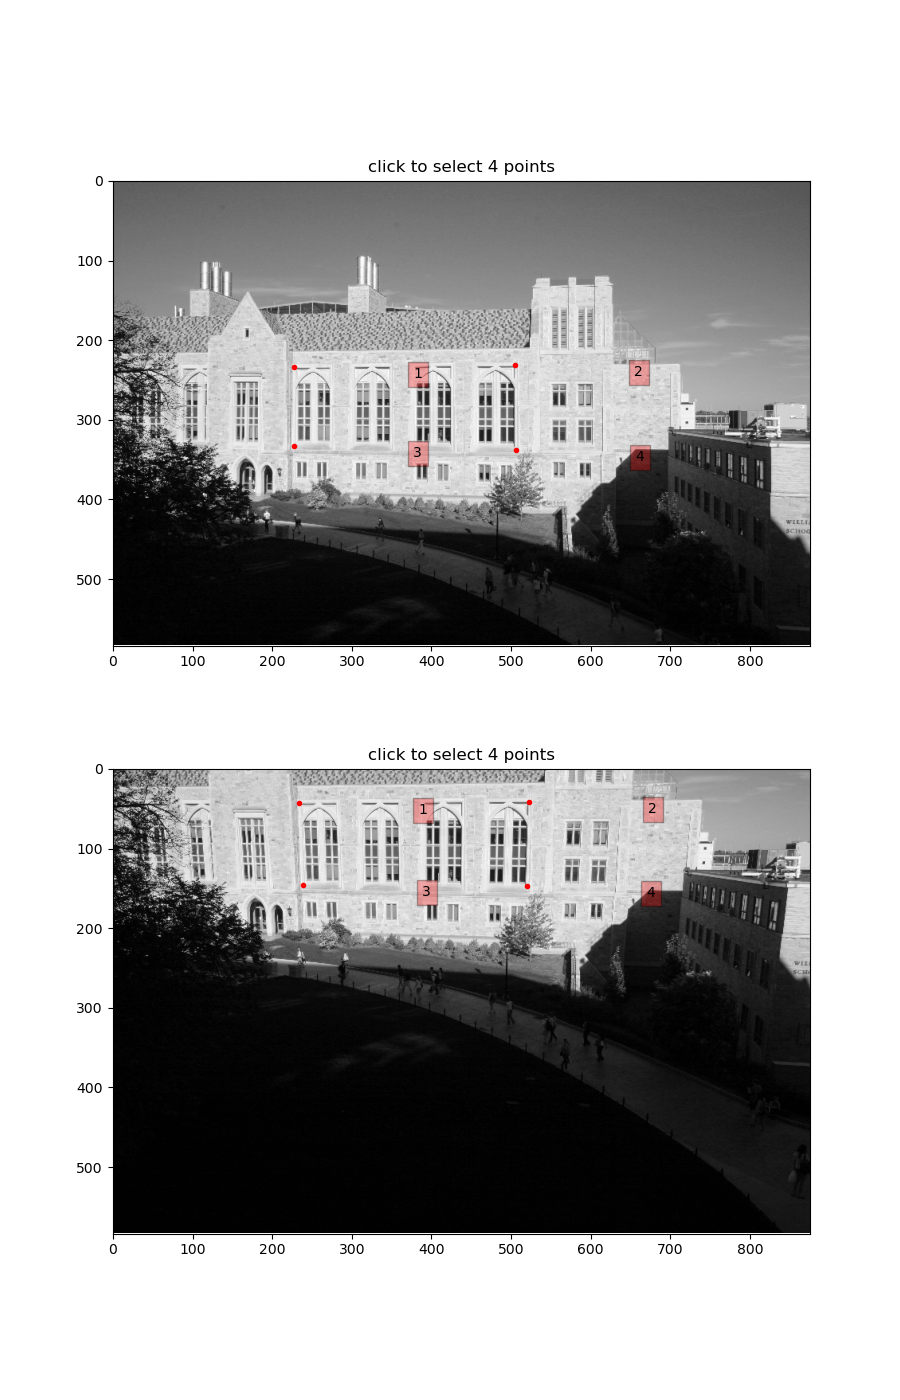

<IPython.core.display.Javascript object>


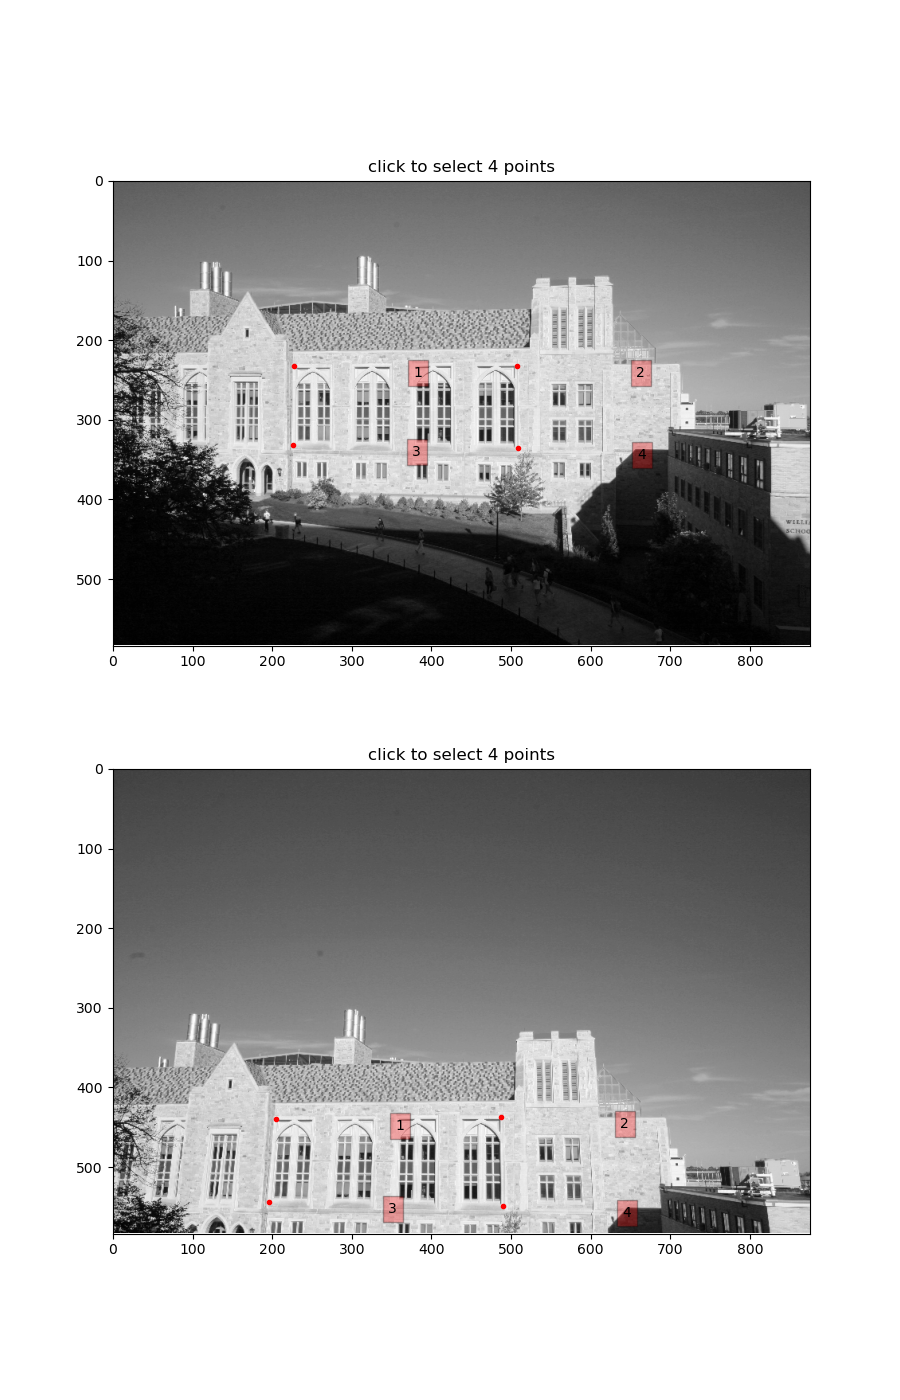

<IPython.core.display.Javascript object>


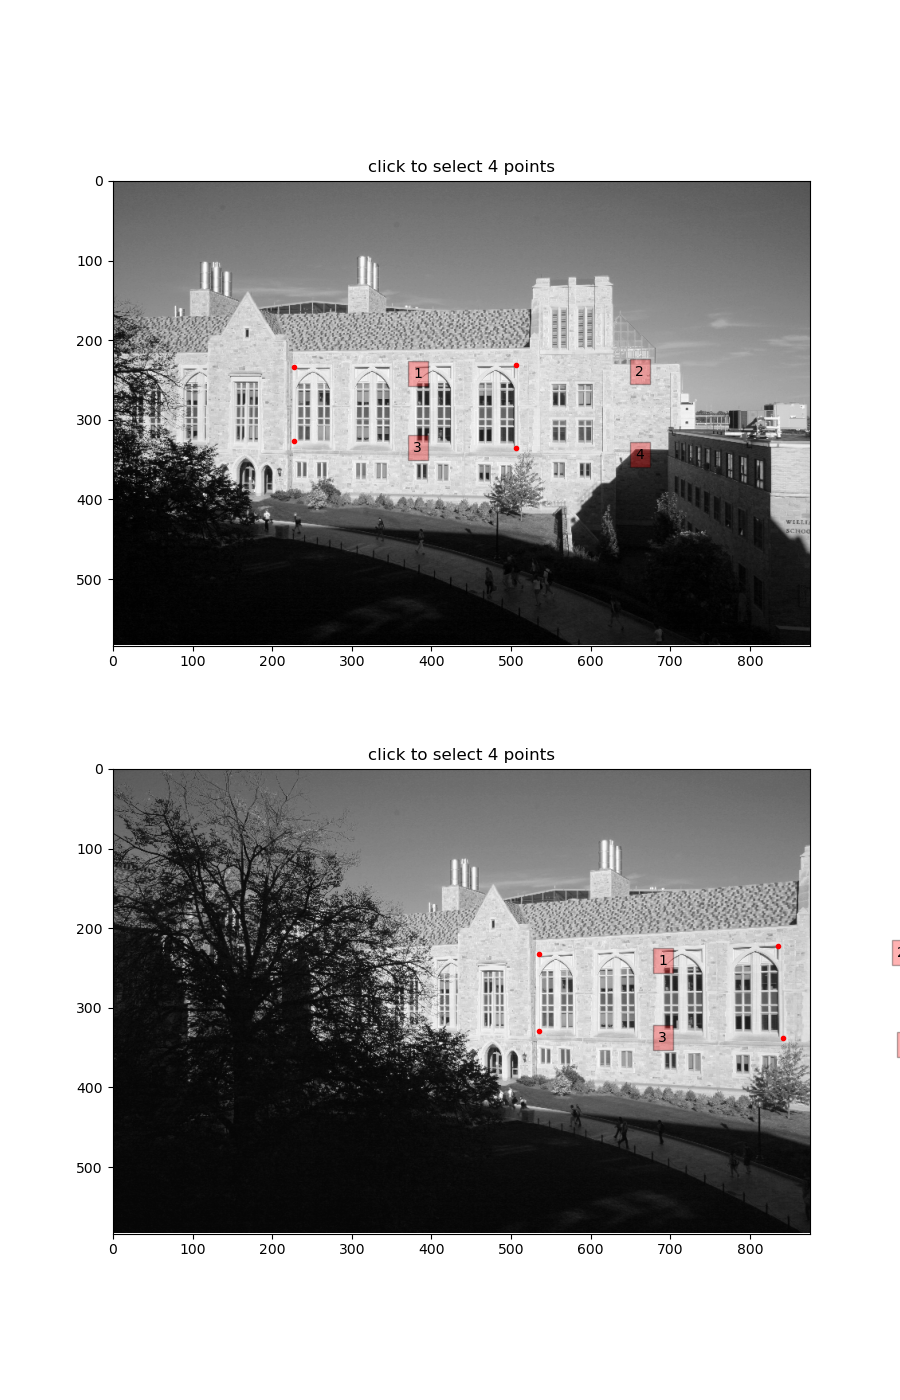

<IPython.core.display.Javascript object>


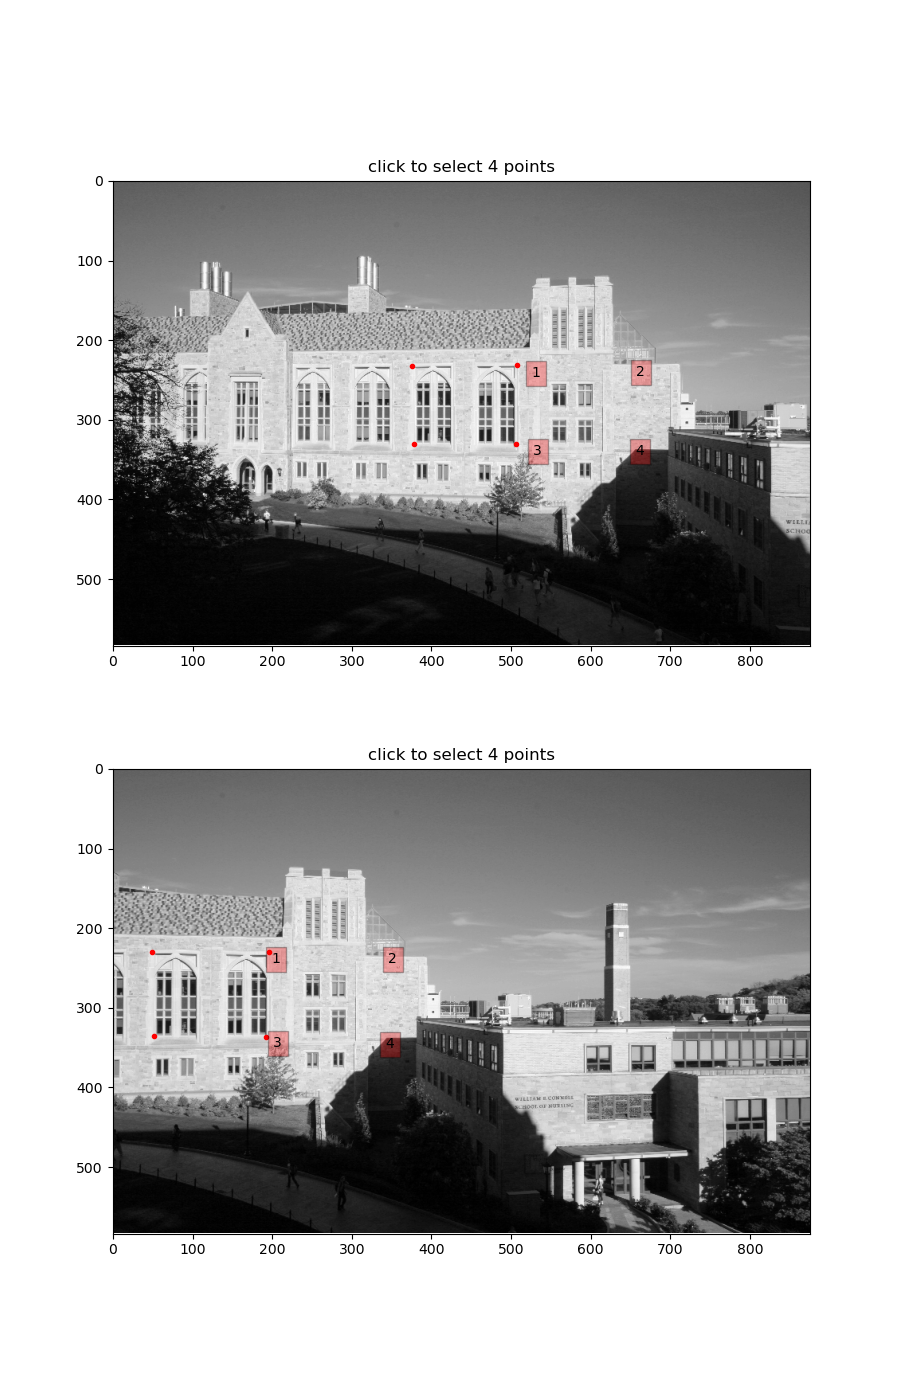

In [6]:
imnames = ('window/IMG_1341.JPG', 'window/IMG_1342.JPG', 'window/IMG_1343.JPG', 'window/IMG_1344.JPG', 'window/IMG_1345.JPG')
baseim = 0   #index of the central base image

#make the default figure size larger to make clicking points easier
plt.rcParams['figure.figsize'] = [9, 14]

#call your function to get user clicks
imgs,pointmatches = get_correspondences(imnames,baseim)

plt.rcParams['figure.figsize'] = [9, 9]

# after executing this cell, we need to stop and click before running to the next cell

<IPython.core.display.Javascript object>


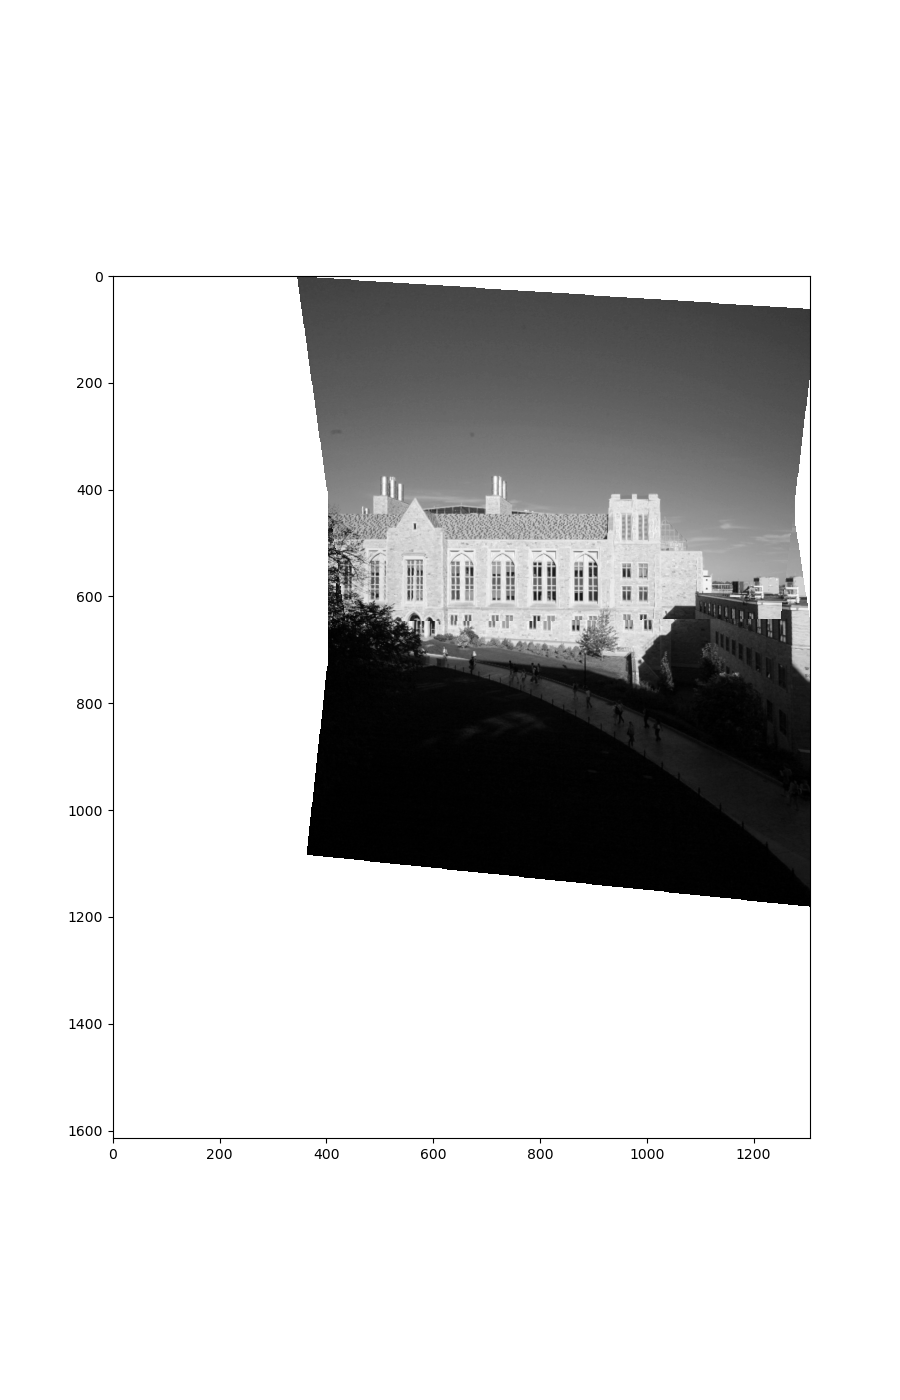

In [8]:
# collect together all the point coordinates into numpy arrays
nimages = len(imnames)
srcpts = list()
basepts = list()
for i in range(nimages-1):
    basepts.append(np.array((pointmatches[i][0].xs,pointmatches[i][0].ys)))
    srcpts.append(np.array((pointmatches[i][1].xs,pointmatches[i][1].ys)))

imgs_warped = warp_images(imgs,baseim,srcpts,basepts)

plt.rcParams['figure.figsize'] = [9, 14]
fig = plt.figure()

fig.add_subplot(1,1,1).imshow(imgs_warped[0],cmap=plt.cm.gray)
fig.add_subplot(1,1,1).imshow(imgs_warped[1],cmap=plt.cm.gray)
fig.add_subplot(1,1,1).imshow(imgs_warped[2],cmap=plt.cm.gray)
plt.show()

plt.rcParams['figure.figsize'] = [9, 9]